In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings
from pylab import rcParams
from ljungbox import *

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline
rcParams['figure.figsize'] = 18, 6

In [3]:
# working with dataset called "Atmospheric CO2 from Continuous 
# Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
y = pd.DataFrame.from_records(sm.datasets.co2.load().data)
y['date'] = y.date.apply(lambda x: x.decode('utf-8'))
y['date'] = pd.to_datetime(y.date, format='%Y%m%d')
y = y.set_index('date')
y.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [4]:
# Weekly data can be tricky to work with since it’s a briefer amount of time, 
# so let's use monthly averages instead.
# The 'MS' string groups the data in buckets by start of the month
y = y['co2'].resample('MS').mean()

In [5]:
# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())
y.head()

date
1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

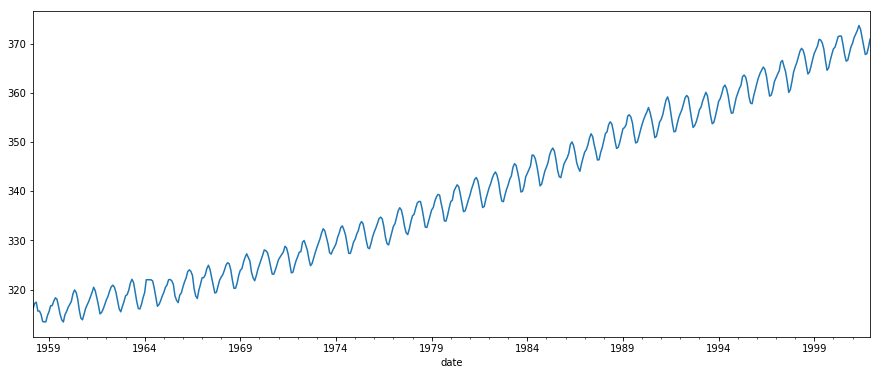

In [6]:
#time series e as a data visualization
y.plot(figsize=(15, 6))
plt.show()

The time series has an obvious seasonality pattern, as well as an overall increasing trend.

# The ARIMA Time Series Model

One of the most common methods used in time series forecasting is known as the ARIMA model, which stands for AutoregRessive Integrated Moving Average. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.

There are three distinct integers (p, d, q) that are used to parametriz

1. p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.

2. d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.

3. q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.



When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. 

Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. 

The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

The seasonal ARIMA method can appear daunting because of the multiple tuning parameters involved.

# Parameter Selection for the ARIMA Time Series Model

When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest.

We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX().

# select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.

We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest.

In [7]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


The code chunk below iterates through combinations of parameters and uses the SARIMAX function from statsmodels to fit the corresponding Seasonal ARIMA model. Here, the order argument specifies the (p, d, q) parameters, while the seasonal_order argument specifies the (P, D, Q, S) seasonal component of the Seasonal ARIMA model. After fitting each SARIMAX()model, the code prints out its respective AIC score.



When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. 


AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [8]:
AIC = []
parm_ = []
parm_s = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            AIC.append(results.aic)
            parm_.append(param)
            parm_s.append(param_seasonal)

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624045894
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.828234141261
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727638985
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320035
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878343061825
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.65789780726
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647912981681
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048754228841
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.6623278300995
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.1941067373248
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716840016
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1090.0766333165652
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:982.8342911419691
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.595789362531
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912987989984
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.8086923024293
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194076
A

In [9]:
min(AIC)

277.78022014777855

In [10]:
pos = AIC.index(min(AIC))

In [11]:
parm_[pos]

(1, 1, 1)

In [12]:
parm_s[pos]

(1, 1, 1, 12)

The output of our code suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 277.78. We should therefore consider this to be optimal option out of all the models we have considered.

# Fitting an ARIMA Time Series Model

In [13]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=parm_[pos],
                                seasonal_order=parm_s[pos],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.162      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.812      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.632      0.000       0.089       0.106


When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions made by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

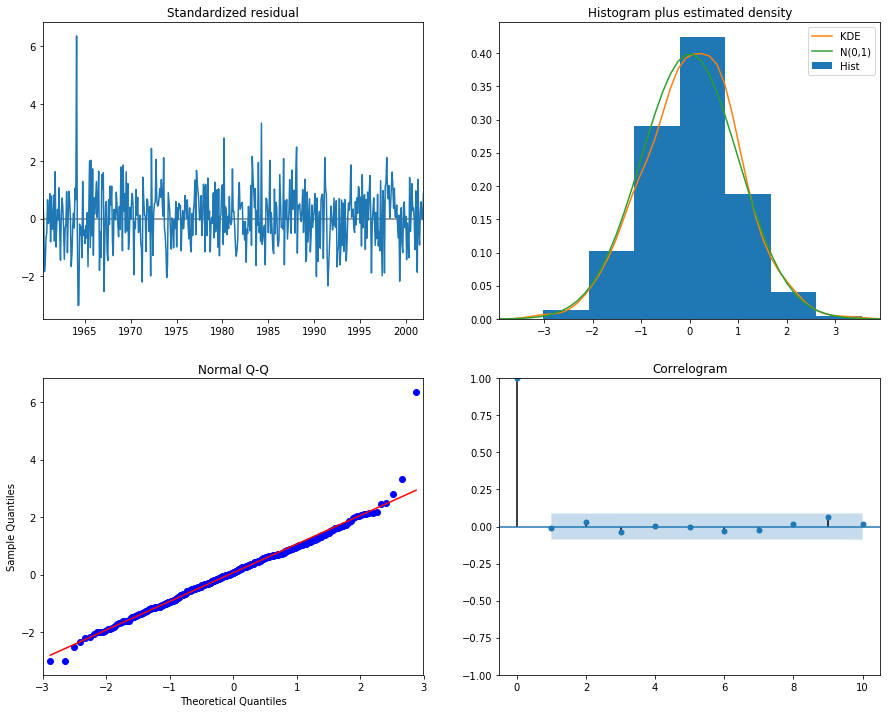

In [14]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [15]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                co2   No. Observations:                  526
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -133.890
Date:                            Sun, 19 May 2019   AIC                            277.780
Time:                                    21:12:17   BIC                            298.843
Sample:                                03-01-1958   HQIC                           286.046
                                     - 12-01-2001                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077   

The summary attribute that results from the output of SARIMAX returns a significant amount of information, but we'll focus our attention on the table of coefficients. 

The coef column shows the weight (i.e. importance) of each feature and how each one impacts the time series. 


The P>|z| column informs us of the significance of each feature weight. 

Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

In [16]:
h, pV, Q, cV = lbqtest(results.resid, range(1, 20), alpha=0.1)
print ('lag   p-value          Q    c-value   rejectH0')
for i in range(len(h)):
    print ("%-2d %10.3f %10.3f %10.3f      %s" % (i+1, pV[i], Q[i], cV[i], str(h[i])))

lag   p-value          Q    c-value   rejectH0
1       0.000     53.819      2.706      True
2       0.000    105.308      4.605      True
3       0.000    156.832      6.251      True
4       0.000    208.435      7.779      True
5       0.000    260.137      9.236      True
6       0.000    311.936     10.645      True
7       0.000    363.830     12.017      True
8       0.000    415.823     13.362      True
9       0.000    467.915     14.684      True
10      0.000    520.106     15.987      True
11      0.000    572.397     17.275      True
12      0.000    624.788     18.549      True
13      0.000    624.862     19.812      True
14      0.000    624.862     21.064      True
15      0.000    624.862     22.307      True
16      0.000    624.862     23.542      True
17      0.000    624.863     24.769      True
18      0.000    624.863     25.989      True
19      0.000    624.863     27.204      True


# Validating Forecasts

We have obtained a model for our time series that can now be used to produce forecasts. We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts. The get_prediction() and conf_int() attributes allow us to obtain the values and associated confidence intervals for forecasts of the time series.

In [17]:
#The code requires the forecasts to start at January 1998
#The dynamic=False argument ensures that we produce one-step ahead forecasts, 
#meaning that forecasts at each point are generated using the full history up to that point.
pred = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_ci = pred.conf_int()

In [18]:
y[y.index >= '1998-01-01'].head()

date
1998-01-01    365.340
1998-02-01    366.200
1998-03-01    367.375
1998-04-01    368.525
1998-05-01    369.140
Freq: MS, Name: co2, dtype: float64

In [19]:
pred_ci.head()

,lower co2,upper co2
date,,
1998-01-01,364.453366,365.675241
1998-02-01,365.373503,366.595377
1998-03-01,366.404744,367.626619
1998-04-01,367.908502,369.130375
1998-05-01,368.389524,369.611398


We can plot the real and forecasted values of the CO2 time series to assess how well we did.

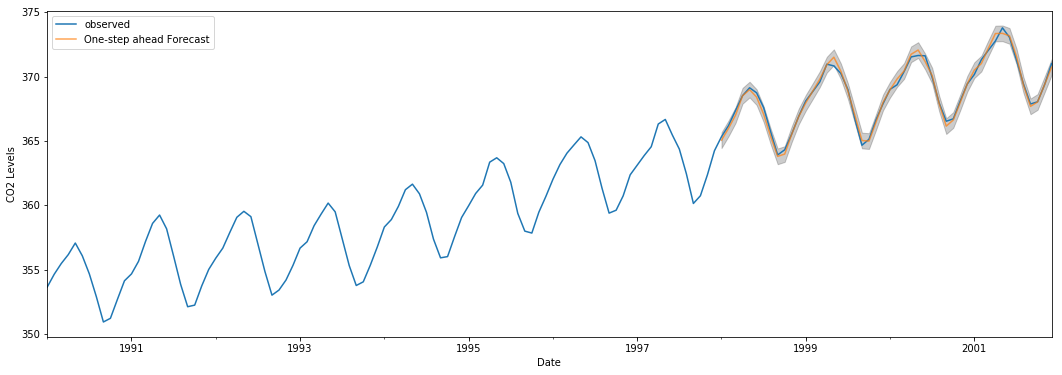

In [20]:
ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()
plt.show()

Compute the MSE (Mean Squared Error), which summarizes the average error of our forecasts. 

For each predicted value, we compute its distance to the true value and square the result. 

The results need to be squared so that positive/negative differences do not cancel each other out when we compute the overall mean.

In [21]:
y_forecasted = pred.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.07


The MSE of our one-step ahead forecasts yields a value of 0.07, which is very low as it is close to 0. An MSE of 0 would that the estimator is predicting observations of the parameter with perfect accuracy, which would be an ideal scenario but it not typically possible.